In [44]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import Image
import qutip
from qutip import *
from tqdm import tqdm
from qutip.solver import correlation_2op_1t
from matplotlib import rc
from scipy.linalg import expm
from scipy.fft import ifftshift
import scipy.signal as signal
from scipy.special import factorial
import matplotlib as mpl
from matplotlib import cm
from brokenaxes import brokenaxes  # Librería para ejes rotos
import pandas as pd
from joblib import Parallel, delayed
import ast
from optomechanics import *

In [45]:
#SYSTEM'S PARAMETERS
hbar=1
kappa= 250e-3 #cavity mode decay rate
g0 = np.logspace(-3, -0.75, 4) #single-photon coupling rate
Omega= 0.005 #laser pumping rate
wm=100e-3 #vibrational mode frequency
wc = 2.5 #cavity mode frequency
gamma_m= 1e-3 #vibrational mode decay rate
n_th=0.02 # phonon thermal excitation
wl = wc #laser's frequency
wlist=np.linspace(2, 3, 10000) #frequency range
Delta= wc-wl #laser detuning
alpha= Omega/(kappa/2 + 1j*Delta) #cavity field amplitude
alpha2= alpha.conjugate()*alpha
g = g0*abs(alpha) #optomechanical coupling rate 

In [3]:
data = []

for i in range(len(g0)):
    Gamma_plus, Gamma_minus, Gamma_opt = Transition_rates(g0[i], alpha2, kappa, Delta, wm)
    nb = pop_phonons(gamma_m, Gamma_opt, n_th, Gamma_plus)
    S = [emission_spec(w, nb, Gamma_plus, Gamma_minus, Gamma_opt, gamma_m, wl, wm) for w in wlist]
    data.append({
        'g0': g0[i],
        'Δ': Delta,
        'nth': n_th,
        'Omega': Omega,
        'Gamma_plus': np.real(Gamma_plus),
        'Gamma_minus': np.real(Gamma_minus),
        'Gamma_opt': np.real(Gamma_opt),
        'Analytical S': np.real(S),
        'Analytical w': wlist,
        'C': g[i]**2/(kappa*gamma_m), #abs(np.real(Gamma_opt) / gamma_m),
        'g/k': g[i]/kappa
    })

# Convert to DataFrame
df_anal = pd.DataFrame(data)

In [4]:
df_anal

,g0,Δ,nth,Omega,Gamma_plus,Gamma_minus,Gamma_opt,Analytical S,Analytical w,C,g/k
0,0.001000,0.0,0.02,0.005,1.560976e-08,1.560976e-08,0.0,"[8.030515796018028e-10, 8.036128561099889e-10,...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000006,0.000160
1,0.005623,0.0,0.02,0.005,4.936238e-07,4.936238e-07,0.0,"[2.5411762172589706e-08, 2.5429522354859176e-0...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.000202,0.000900
2,0.031623,0.0,0.02,0.005,1.560976e-05,1.560976e-05,0.0,"[8.206319494515276e-07, 8.212046363671766e-07,...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.006400,0.005060
3,0.177828,0.0,0.02,0.005,4.936238e-04,4.936238e-04,0.0,"[4.299213202231468e-05, 4.302130261204712e-05,...","[2.0, 2.0001000100010002, 2.000200020002, 2.00...",0.202386,0.028452


In [5]:
#Store data
#Name code: Folder/Test_parameter_hamiltonian_anal (in anal we will store the analytical solutions and system's parameters)
df_anal.to_pickle("Test for t range/Test_t_full_anal.pkl")
df_anal.to_pickle("Test for HS range/Test_HS_full_anal.pkl")

## Time range convergency test

In [9]:
#NUMERICAL SIMULATION
#Hamiltonian construction
Nc = [12]  # Number of cavity states
Nm = [6]  # Number of mech states
time= np.arange(100,35000,600)  #[30000] np.arange(1000,35000,1500)
data=[]
for j in range(len(g0)):
    for i in range(len(Nc)):
        for t in time:
            tlist=np.linspace(0, t, 50000)
            dt=tlist[1]-tlist[0]
            a = tensor(destroy(N=Nc[i]), qeye(Nm[i]))
            b = tensor(qeye(Nc[i]), destroy(N=Nm[i]))
            num_b = b.dag() * b
            num_a = a.dag() * a
            c_ops = [np.sqrt(kappa)*a, np.sqrt((n_th+1)*gamma_m)*b, np.sqrt(n_th*gamma_m)*b.dag()]
            #Choose between the two Hamiltonians
            Hlin = hbar*wm*num_b+hbar*Delta*num_a-hbar*abs(alpha)*g0[j]*(a.dag()+a)*(b.dag()+b)
            H = hbar*Delta*num_a+hbar*wm*num_b+1j*Omega*(a.dag()-a)-g0[j]*num_a*(b.dag()+b)
            data.append([g0[j], t, dt, tlist, Nc[i], Nm[i], H, c_ops, a, b])

new_data = pd.DataFrame(data, columns=['g0', 't', 'dt', 'tlist', 'Nc', 'Nm', 'Hamiltonian', 'c_ops', 'a', 'b'])
df = pd.DataFrame(new_data)

In [10]:
df

,g0,t,dt,tlist,Nc,Nm,Hamiltonian,c_ops,a,b
0,0.001000,100,0.002000,"[0.0, 0.002000040000800016, 0.0040000800016000...",12,6,"Quantum object: dims=[[12, 6], [12, 6]], shape...","[Quantum object: dims=[[12, 6], [12, 6]], shap...","Quantum object: dims=[[12, 6], [12, 6]], shape...","Quantum object: dims=[[12, 6], [12, 6]], shape..."
1,0.001000,700,0.014000,"[0.0, 0.014000280005600113, 0.0280005600112002...",12,6,"Quantum object: dims=[[12, 6], [12, 6]], shape...","[Quantum object: dims=[[12, 6], [12, 6]], shap...","Quantum object: dims=[[12, 6], [12, 6]], shape...","Quantum object: dims=[[12, 6], [12, 6]], shape..."
2,0.001000,1300,0.026001,"[0.0, 0.026000520010400208, 0.0520010400208004...",12,6,"Quantum object: dims=[[12, 6], [12, 6]], shape...","[Quantum object: dims=[[12, 6], [12, 6]], shap...","Quantum object: dims=[[12, 6], [12, 6]], shape...","Quantum object: dims=[[12, 6], [12, 6]], shape..."
3,0.001000,1900,0.038001,"[0.0, 0.0380007600152003, 0.0760015200304006, ...",12,6,"Quantum object: dims=[[12, 6], [12, 6]], shape...","[Quantum object: dims=[[12, 6], [12, 6]], shap...","Quantum object: dims=[[12, 6], [12, 6]], shape...","Quantum object: dims=[[12, 6], [12, 6]], shape..."
4,0.001000,2500,0.050001,"[0.0, 0.0500010000200004, 0.1000020000400008, ...",12,6,"Quantum object: dims=[[12, 6], [12, 6]], shape...","[Quantum object: dims=[[12, 6], [12, 6]], shap...","Quantum object: dims=[[12, 6], [12, 6]], shape...","Quantum object: dims=[[12, 6], [12, 6]], shape..."
...,...,...,...,...,...,...,...,...,...,...
231,0.177828,32500,0.650013,"[0.0, 0.6500130002600052, 1.3000260005200104, ...",12,6,"Quantum object: dims=[[12, 6], [12, 6]], shape...","[Quantum object: dims=[[12, 6], [12, 6]], shap...","Quantum object: dims=[[12, 6], [12, 6]], shape...","Quantum object: dims=[[12, 6], [12, 6]], shape..."
232,0.177828,33100,0.662013,"[0.0, 0.6620132402648053, 1.3240264805296107, ...",12,6,"Quantum object: dims=[[12, 6], [12, 6]], shape...","[Quantum object: dims=[[12, 6], [12, 6]], shap...","Quantum object: dims=[[12, 6], [12, 6]], shape...","Quantum object: dims=[[12, 6], [12, 6]], shape..."
233,0.177828,33700,0.674013,"[0.0, 0.6740134802696054, 1.3480269605392108, ...",12,6,"Quantum object: dims=[[12, 6], [12, 6]], shape...","[Quantum object: dims=[[12, 6], [12, 6]], shap...","Quantum object: dims=[[12, 6], [12, 6]], shape...","Quantum object: dims=[[12, 6], [12, 6]], shape..."
234,0.177828,34300,0.686014,"[0.0, 0.6860137202744054, 1.3720274405488109, ...",12,6,"Quantum object: dims=[[12, 6], [12, 6]], shape...","[Quantum object: dims=[[12, 6], [12, 6]], shap...","Quantum object: dims=[[12, 6], [12, 6]], shape...","Quantum object: dims=[[12, 6], [12, 6]], shape..."


In [11]:
%%time

results1 = Parallel(n_jobs=8)(delayed(spectrum_calculation)(df['Hamiltonian'][i], df['tlist'][i], wl, wm, df['c_ops'][i], df['a'][i], df['b'][i]) for i in tqdm(range(len(df))))
for key in results1[0].keys():
    df[key] = [res[key] for res in results1]

100%|██████████| 236/236 [2:40:29<00:00, 40.80s/it] 


CPU times: total: 1min 17s
Wall time: 3h 48min 57s


In [13]:
#Store data
#Name code: Folder/Test_parameter_hamiltonian_num (in num we will store the numerical solutions)
df.to_pickle("Test for t range (g0)/Test_t_full_num.pkl")

In [33]:
#Load data
df_anal=pd.read_pickle("Test for t range (g0)/Test_t_full_anal.pkl")
df=pd.read_pickle("Test for t range (g0)/Test_t_full_num.pkl") 

In [36]:
#Calulate frequency resolution
dw=[]
for i in range(len(df)):
    dw.append(df['w'][i][7]-df['w'][i][6])
df['dw']=dw

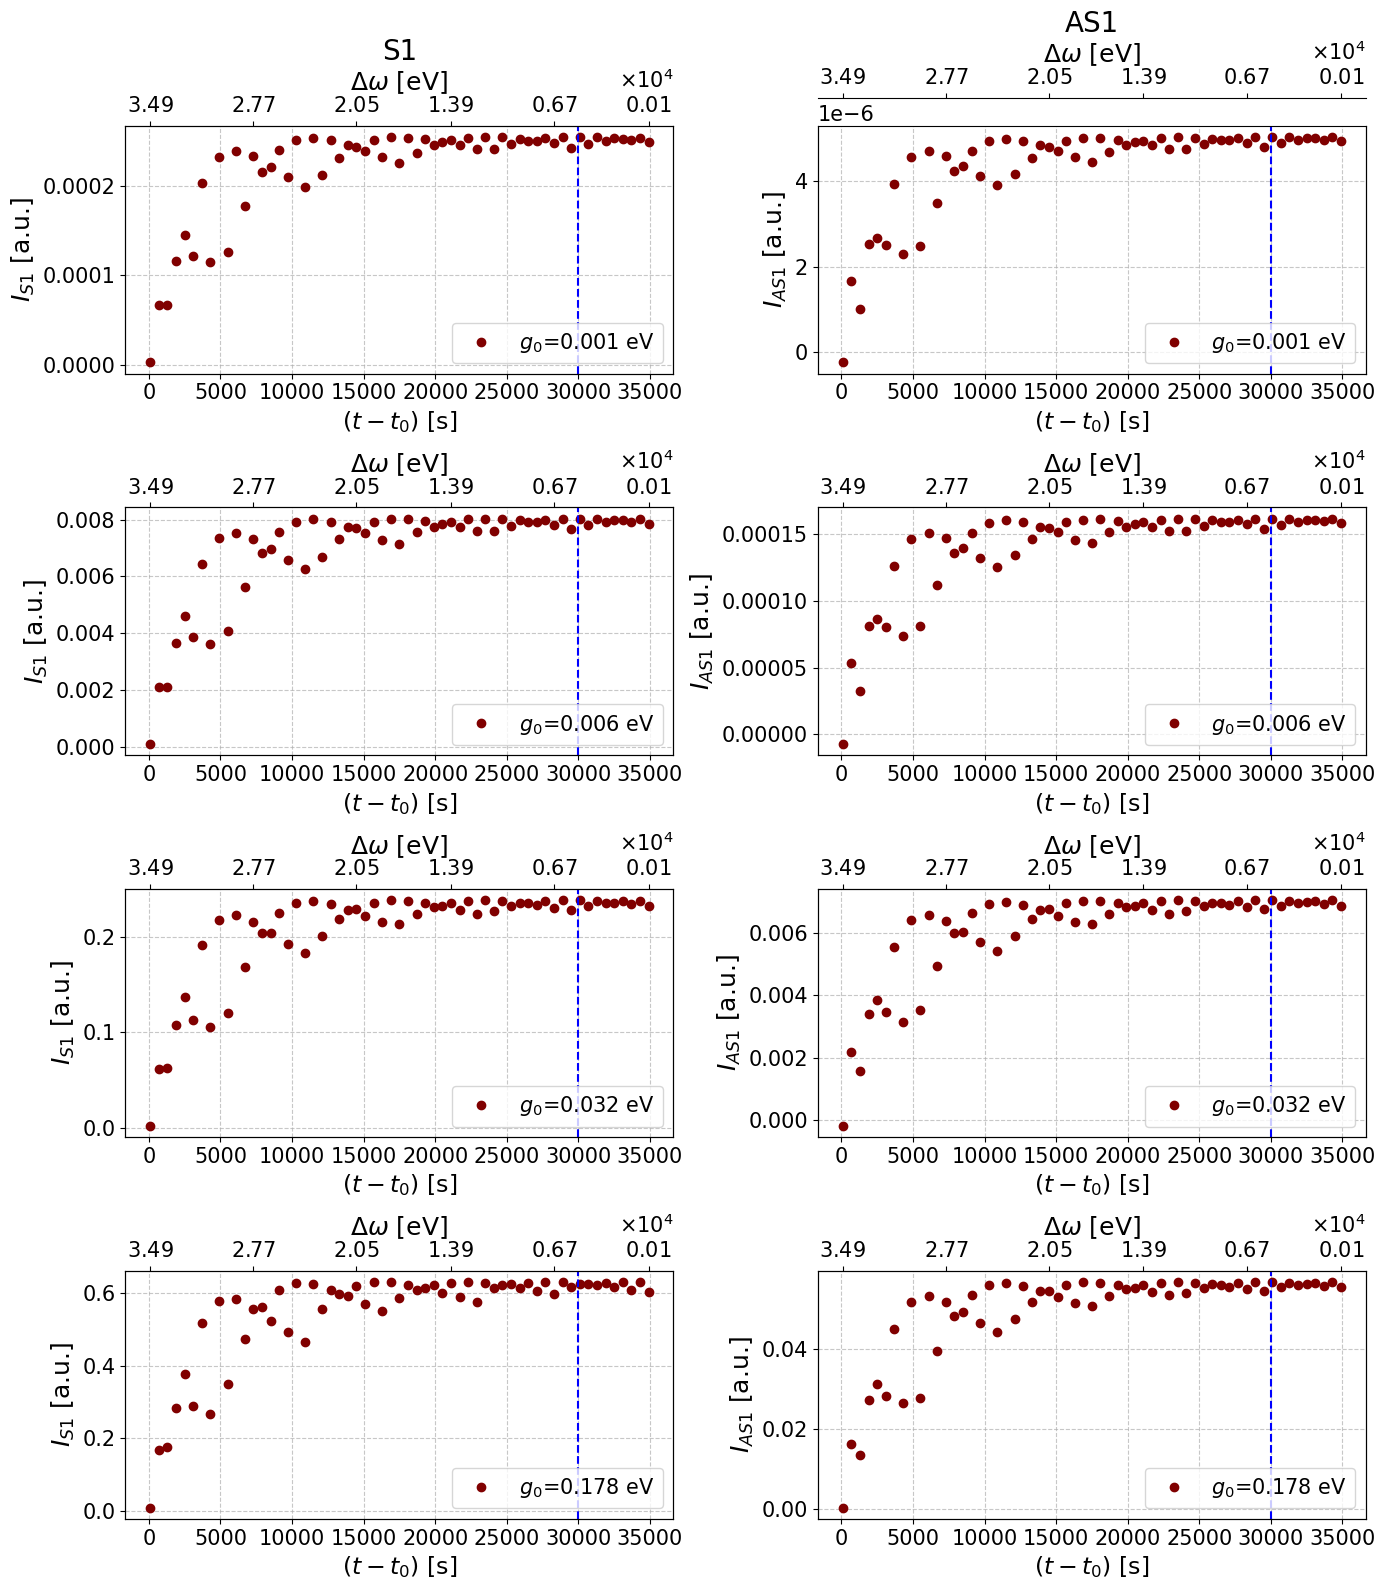

In [40]:
import matplotlib.ticker as mticker
fig, axes = plt.subplots(4, 2, figsize=(14, 16))

for g in range(len(g0)):
    data = df[df['g0'] == g0[g]]

    t_vals = data['t'].values       # eje inferior
    x = data['dw'].values           # eje superior (invertido)
    y1 = data['S1'].values
    y2 = data['AS1'].values

    for i, y in enumerate([y1, y2]):
        ax = axes[g,i]
        ax.plot(t_vals, y, 'o', color='maroon', label=fr'$g_0$={g0[g]:.3f} eV')
        ax.plot(t_vals, y, 'o', color='maroon', label=fr'$g_0$={g0[g]:.3f} eV')
        ax.axvline(x= 30000, linestyle='--', color='blue')
        ax.set_xlabel(r"$(t-t_0)$ [s]", fontsize=17)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.tick_params(axis='both', labelsize=15)
        ax.yaxis.get_offset_text().set_fontsize(15)
        ax.legend(loc='lower right', fontsize=15)

        top_ax = ax.twiny()
        top_ax.set_xlim(ax.get_xlim())  # sincronizamos límites con eje inferior
        
        top_ax.invert_xaxis()  # invertimos el eje superior
        
        idx = np.linspace(0, len(x) - 1, 6, dtype=int)
        
        # Invertimos el orden de los ticks y etiquetas para que cuadren con el eje invertido
        ticks_positions = t_vals[idx][::-1]       # posiciones de los ticks en t, invertidas
        ticks_labels = [f"{val:.3f}" for val in x[idx]]  # etiquetas invertidas de dw
        
        top_ax.set_xticks(ticks_positions)
        top_ax.set_xticklabels(ticks_labels)
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((0, 0))
        top_ax.xaxis.set_major_formatter(formatter)
        if g==0 and i==1:
            top_ax.spines['top'].set_position(('outward', 20))
        top_ax.set_xlabel(r"$\Delta \omega$ [eV]", fontsize=18)
        top_ax.tick_params(labelsize=15)
        top_ax.xaxis.get_offset_text().set_fontsize(15)

    axes[g,0].set_ylabel(r"$I_{S1}$ [a.u.]", fontsize=18)
    axes[g,1].set_ylabel(r"$I_{AS1}$ [a.u.]", fontsize=18)

    if g == 0:
        axes[0,0].set_title(r"S1", fontsize=20)
        axes[0,1].set_title(r"AS1", fontsize=20)

plt.tight_layout()
plt.savefig("Test for t range (g0)/Convergency_of_signals.pdf", format='pdf', bbox_inches='tight')
plt.show()

------------------------

## Hilbert Space convergency test 

In [7]:
#NUMERICAL SIMULATION
#Hamiltonian construction
Nc = [4, 6, 8, 10, 12, 14, 16]  # Dimension of cavity states
Nm = [2, 4, 6, 8, 10, 12, 14]  # Dimension of vibrational states
time= [30000]  #Time range
data=[]
for j in range(len(g0)):
    for i in range(len(Nc)):
        for t in time:
            tlist=np.linspace(0, t, 50000)
            dt=tlist[1]-tlist[0]
            a = tensor(destroy(N=Nc[i]), qeye(Nm[i]))
            b = tensor(qeye(Nc[i]), destroy(N=Nm[i]))
            num_b = b.dag() * b
            num_a = a.dag() * a
            c_ops = [np.sqrt(kappa)*a, np.sqrt((n_th+1)*gamma_m)*b, np.sqrt(n_th*gamma_m)*b.dag()]
            #Choose bewteen the two Hamiltonians
            Hlin = hbar*wm*num_b+hbar*Delta*num_a-hbar*abs(alpha)*g0[j]*(a.dag()+a)*(b.dag()+b)
            H = hbar*Delta*num_a+hbar*wm*num_b+1j*Omega*(a.dag()-a)-g0[j]*num_a*(b.dag()+b)
            data.append([g0[j], t, dt, tlist, Nc[i], Nm[i], H, c_ops, a, b])

new_data = pd.DataFrame(data, columns=['g0', 't', 'dt', 'tlist', 'Nc', 'Nm', 'Hamiltonian', 'c_ops', 'a', 'b'])
df = pd.DataFrame(new_data)

In [8]:
df

,g0,t,dt,tlist,Nc,Nm,Hamiltonian,c_ops,a,b
0,0.001000,30000,0.600012,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",4,2,"Quantum object: dims=[[4, 2], [4, 2]], shape=(...","[Quantum object: dims=[[4, 2], [4, 2]], shape=...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...","Quantum object: dims=[[4, 2], [4, 2]], shape=(..."
1,0.001000,30000,0.600012,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",6,4,"Quantum object: dims=[[6, 4], [6, 4]], shape=(...","[Quantum object: dims=[[6, 4], [6, 4]], shape=...","Quantum object: dims=[[6, 4], [6, 4]], shape=(...","Quantum object: dims=[[6, 4], [6, 4]], shape=(..."
2,0.001000,30000,0.600012,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",8,6,"Quantum object: dims=[[8, 6], [8, 6]], shape=(...","[Quantum object: dims=[[8, 6], [8, 6]], shape=...","Quantum object: dims=[[8, 6], [8, 6]], shape=(...","Quantum object: dims=[[8, 6], [8, 6]], shape=(..."
3,0.001000,30000,0.600012,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",10,8,"Quantum object: dims=[[10, 8], [10, 8]], shape...","[Quantum object: dims=[[10, 8], [10, 8]], shap...","Quantum object: dims=[[10, 8], [10, 8]], shape...","Quantum object: dims=[[10, 8], [10, 8]], shape..."
4,0.001000,30000,0.600012,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",12,10,"Quantum object: dims=[[12, 10], [12, 10]], sha...","[Quantum object: dims=[[12, 10], [12, 10]], sh...","Quantum object: dims=[[12, 10], [12, 10]], sha...","Quantum object: dims=[[12, 10], [12, 10]], sha..."
5,0.001000,30000,0.600012,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",14,12,"Quantum object: dims=[[14, 12], [14, 12]], sha...","[Quantum object: dims=[[14, 12], [14, 12]], sh...","Quantum object: dims=[[14, 12], [14, 12]], sha...","Quantum object: dims=[[14, 12], [14, 12]], sha..."
6,0.001000,30000,0.600012,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",16,14,"Quantum object: dims=[[16, 14], [16, 14]], sha...","[Quantum object: dims=[[16, 14], [16, 14]], sh...","Quantum object: dims=[[16, 14], [16, 14]], sha...","Quantum object: dims=[[16, 14], [16, 14]], sha..."
7,0.005623,30000,0.600012,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",4,2,"Quantum object: dims=[[4, 2], [4, 2]], shape=(...","[Quantum object: dims=[[4, 2], [4, 2]], shape=...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...","Quantum object: dims=[[4, 2], [4, 2]], shape=(..."
8,0.005623,30000,0.600012,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",6,4,"Quantum object: dims=[[6, 4], [6, 4]], shape=(...","[Quantum object: dims=[[6, 4], [6, 4]], shape=...","Quantum object: dims=[[6, 4], [6, 4]], shape=(...","Quantum object: dims=[[6, 4], [6, 4]], shape=(..."
9,0.005623,30000,0.600012,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",8,6,"Quantum object: dims=[[8, 6], [8, 6]], shape=(...","[Quantum object: dims=[[8, 6], [8, 6]], shape=...","Quantum object: dims=[[8, 6], [8, 6]], shape=(...","Quantum object: dims=[[8, 6], [8, 6]], shape=(..."


In [9]:
%%time

results1 = Parallel(n_jobs=8)(delayed(spectrum_calculation)(df['Hamiltonian'][i], df['tlist'][i], wl, wm, df['c_ops'][i], df['a'][i], df['b'][i]) for i in tqdm(range(len(df))))
for key in results1[0].keys():
    df[key] = [res[key] for res in results1]

100%|██████████| 28/28 [06:06<00:00, 13.10s/it]


CPU times: total: 2min 53s
Wall time: 6h 54min 59s


In [10]:
#Store data
#Name code: Test_parameter_hamiltonian_num (in num we will store the numerical solutions)
df.to_pickle("Test for HS range (g0)/Test_HS_full_num.pkl")

In [46]:
#Load data
df_anal=pd.read_pickle("Test for HS range (g0)/Test_HS_full_anal.pkl")
df=pd.read_pickle("Test for HS range (g0)/Test_HS_full_num.pkl") 

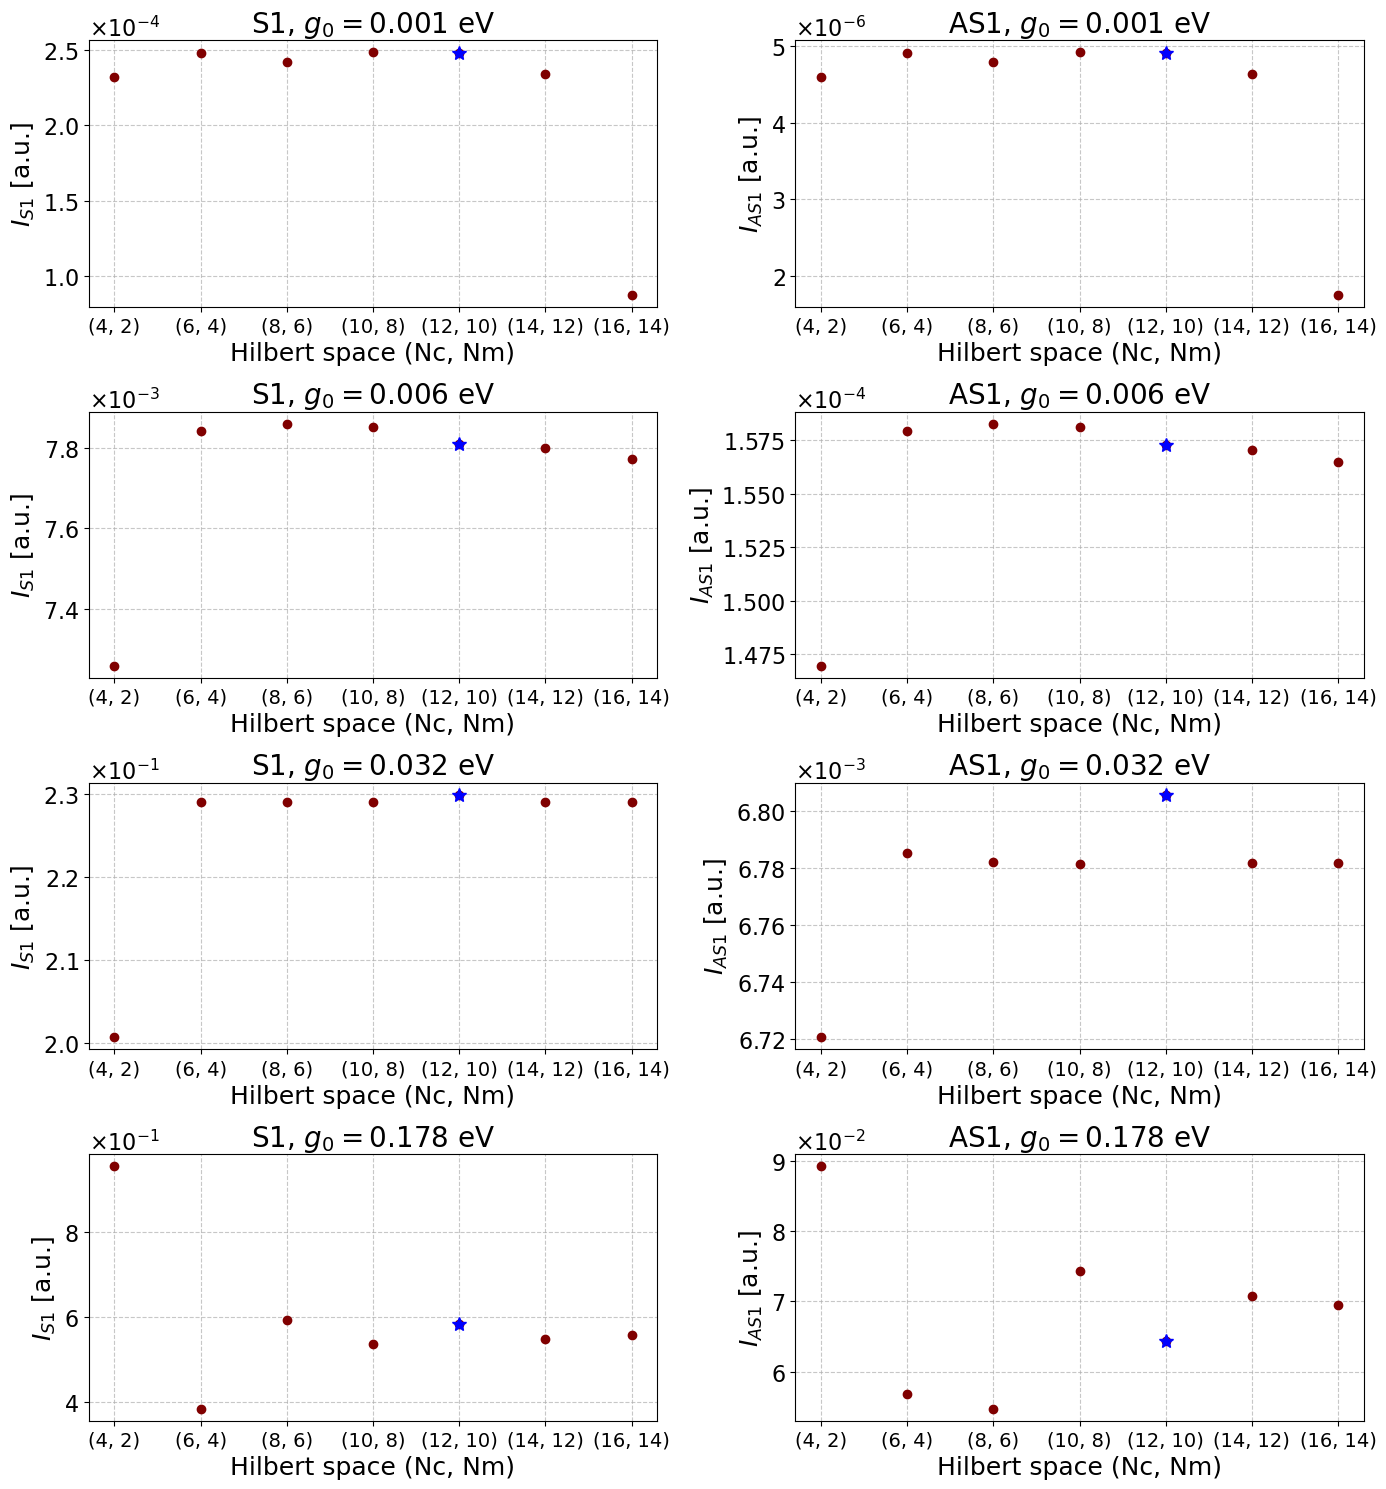

In [30]:
data=df[df['g0']==g0[0]]
x=[]
for i in range(len(data)):
    x.append((df['Nc'][i], df['Nm'][i]))
#formatter = FuncFormatter(lambda y, _: f'{y:.1e}')
fig, axes = plt.subplots(4,2, figsize=(14, 15))
for g in range(len(g0)):
    s1=df[df['g0']==g0[g]]['S1'].values
    as1=df[df['g0']==g0[g]]['AS1'].values
    # Convertimos las tuplas a strings para que se puedan usar como etiquetas
    x_labels = [str(t) for t in x]
    x_pos = range(len(x))
    axes[g,0].plot(x_pos, s1, 'o', color='maroon')
    axes[g,0].plot(x_pos[4], s1[4], '*', color='blue', markersize=10)
    axes[g,0].set_xticks(x_pos)
    axes[g,0].set_xticklabels(x_labels)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    axes[g,0].yaxis.set_major_formatter(formatter)
    
    axes[g,1].plot(x_pos, as1, 'o', color='maroon')
    axes[g,1].plot(x_pos[4], as1[4], '*', color='blue', markersize=10)
    axes[g,1].set_xticks(x_pos)
    axes[g,1].set_xticklabels(x_labels)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    axes[g,1].yaxis.set_major_formatter(formatter)

    
    for i in range(2):
        axes[g,i].tick_params(axis='x', labelsize=14)
        axes[g,i].set_xlabel('Hilbert space (Nc, Nm)', fontsize=18)
        axes[g,i].grid(True, linestyle='--', alpha=0.7)
        axes[g,i].tick_params(axis='y', labelsize=16)
        axes[g,i].yaxis.get_offset_text().set_fontsize(16)
        #axes[i].invert_xaxis() 
    axes[g,0].set_ylabel(r"$I_{S1}$ [a.u.]", fontsize=18)
    axes[g,1].set_ylabel(r"$I_{AS1}$ [a.u.]", fontsize=18)
    
    axes[g,0].set_title(r"S1, $g_0=$"+f'{g0[g]:.3f} eV', fontsize=20)
    axes[g,1].set_title(r"AS1, $g_0=$"+f'{g0[g]:.3f} eV', fontsize=20)

plt.tight_layout()
plt.savefig("Test for HS range (g0)/Convergency_of_signalsHS.pdf", format='pdf', bbox_inches='tight')
plt.show()